## MNIST Handwritten Digits Classification Experiment

This demo shows how you can use SageMaker Experiment Management Python SDK to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyper-parameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs will be automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before/after model training e.g. data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best performing models.

Now we will demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment will be organized as follow:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyper parameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of Python SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We will also see an example of tracing the complete linage of a model version i.e. the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you selected `Python 3 (Data Science)` kernel.

### Install Python SDKs

Install first all requirements.txt

In [1]:
import sys

### Setup

In [9]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

<ipython-input-9-690bb9304a60>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


In [6]:
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='training2-access-role')['Role']['Arn']
    
print(role)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


arn:aws:iam::449196135517:role/training2-access-role


In [10]:
sess = boto3.Session()
sm = sess.client("sagemaker")
role = get_execution_role()

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


### Create a S3 bucket to hold data

In [11]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client("sts").get_caller_identity()["Account"]
bucket = "sagemaker-experiments-{}-{}".format(sess.region_name, account_id)
prefix = "mnist"

try:
    if sess.region_name == "us-east-1":
        sess.client("s3").create_bucket(Bucket=bucket)
    else:
        sess.client("s3").create_bucket(
            Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": sess.region_name}
        )
except Exception as e:
    print(e)

### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [12]:
# TODO: can be removed after upgrade to torchvision==0.9.1
# see github.com/pytorch/vision/issues/1938 and github.com/pytorch/vision/issues/3549
datasets.MNIST.urls = [
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz",
]

# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST(
    "mnist",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

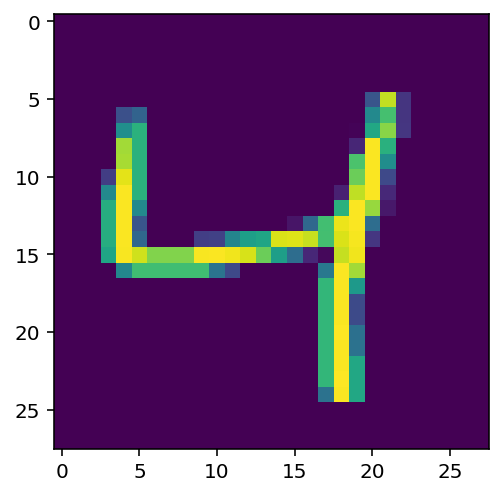

In [13]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [14]:
inputs = sagemaker.Session().upload_data(path="mnist", bucket=bucket, key_prefix=prefix)
print("input spec: {}".format(inputs))

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


input spec: s3://sagemaker-experiments-us-east-1-449196135517/mnist


Now lets track the parameters from the data pre-processing step.

In [15]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters(
        {
            "normalization_mean": 0.1307,
            "normalization_std": 0.3081,
        }
    )
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [16]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}",
    description="Classification of mnist hand-written digits",
    sagemaker_boto_client=sm,
)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f658c2684f0>,experiment_name='mnist-hand-written-digits-classification-1627622985',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:449196135517:experiment/mnist-hand-written-digits-classification-1627622985',response_metadata={'RequestId': '094f5457-effc-4f34-a50f-02ca861b8680', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '094f5457-effc-4f34-a50f-02ca861b8680', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Fri, 30 Jul 2021 05:29:47 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [17]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [18]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [19]:
preprocessing_trial_component = tracker.trial_component

In [20]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name

    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)

    # all input configurations, parameters, and metrics specified in estimator
    # definition are automatically tracked
    estimator = PyTorch(
        py_version="py3",
        entry_point="./mnist.py",
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version="1.1.0",
        instance_count=1,
        instance_type="ml.c4.xlarge",
        hyperparameters={
            "epochs": 2,
            "backend": "gloo",
            "hidden_channels": num_hidden_channel,
            "dropout": 0.2,
            "kernel_size": 5,
            "optimizer": "sgd",
        },
        metric_definitions=[
            {"Name": "train:loss", "Regex": "Train Loss: (.*?);"},
            {"Name": "test:loss", "Regex": "Test Average loss: (.*?),"},
            {"Name": "test:accuracy", "Regex": "Test Accuracy: (.*?)%;"},
        ],
        enable_sagemaker_metrics=True,
    )

    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))

    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={"training": inputs},
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )

    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1627623020


2021-07-30 05:30:26 Starting - Starting the training job...
2021-07-30 05:30:50 Starting - Launching requested ML instancesProfilerReport-1627623022: InProgress
......
2021-07-30 05:31:50 Starting - Preparing the instances for training......
2021-07-30 05:33:07 Downloading - Downloading input data...
2021-07-30 05:33:42 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-30 05:33:43,724 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-30 05:33:43,727 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-30 05:33:43,738 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-30 05:33:43,740 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-30 05:33:51,226 sagemaker-containers INFO     Module mnist does no


2021-07-30 05:34:47 Uploading - Uploading generated training model
2021-07-30 05:34:47 Completed - Training job completed
Training seconds: 100
Billable seconds: 100


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1627623301


2021-07-30 05:35:07 Starting - Starting the training job...
2021-07-30 05:35:31 Starting - Launching requested ML instancesProfilerReport-1627623303: InProgress
......
2021-07-30 05:36:31 Starting - Preparing the instances for training......
2021-07-30 05:37:51 Downloading - Downloading input data...
2021-07-30 05:38:22 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-30 05:38:24,587 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-30 05:38:24,590 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-30 05:38:24,601 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-30 05:38:24,602 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-30 05:38:25,009 sagemaker-containers INFO     Module mnist does no


2021-07-30 05:39:22 Uploading - Uploading generated training model
2021-07-30 05:39:22 Completed - Training job completed
Training seconds: 92
Billable seconds: 92


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1627623583


2021-07-30 05:39:49 Starting - Starting the training job...
2021-07-30 05:40:13 Starting - Launching requested ML instancesProfilerReport-1627623585: InProgress
......
2021-07-30 05:41:13 Starting - Preparing the instances for training......
2021-07-30 05:42:29 Downloading - Downloading input data...
2021-07-30 05:43:02 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-30 05:43:03,309 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-30 05:43:03,312 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-30 05:43:03,323 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-30 05:43:03,324 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-30 05:43:06,966 sagemaker-containers INFO     Module mnist does no


2021-07-30 05:44:11 Uploading - Uploading generated training model
2021-07-30 05:44:11 Completed - Training job completed
Test Average loss: 0.1060, Test Accuracy: 97%;

Saving the model.
2021-07-30 05:43:58,782 sagemaker-containers INFO     Reporting training SUCCESS
Training seconds: 102
Billable seconds: 102


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1627623864


2021-07-30 05:44:30 Starting - Starting the training job...
2021-07-30 05:44:53 Starting - Launching requested ML instancesProfilerReport-1627623866: InProgress
...
2021-07-30 05:45:34 Starting - Preparing the instances for training.........
2021-07-30 05:47:00 Downloading - Downloading input data
2021-07-30 05:47:00 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-30 05:47:21,764 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-30 05:47:21,766 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-30 05:47:21,778 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-30 05:47:23,196 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-30 05:47:26,528 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Gener


2021-07-30 05:48:41 Uploading - Uploading generated training model
2021-07-30 05:48:41 Completed - Training job completed
Training seconds: 113
Billable seconds: 113


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1627624146


2021-07-30 05:49:12 Starting - Starting the training job...
2021-07-30 05:49:36 Starting - Launching requested ML instancesProfilerReport-1627624148: InProgress
......
2021-07-30 05:50:36 Starting - Preparing the instances for training......
2021-07-30 05:51:51 Downloading - Downloading input data...
2021-07-30 05:52:29 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-30 05:52:30,843 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-30 05:52:30,846 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-30 05:52:30,857 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-30 05:52:31,071 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-30 05:52:31,377 sagemaker-containers INFO     Module mnist does no

Test Average loss: 0.1012, Test Accuracy: 97%;

Saving the model.
2021-07-30 05:53:40,333 sagemaker-containers INFO     Reporting training SUCCESS

2021-07-30 05:53:57 Uploading - Uploading generated training model
2021-07-30 05:53:57 Completed - Training job completed
ProfilerReport-1627624148: NoIssuesFound
Training seconds: 118
Billable seconds: 118


### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [21]:
search_expression = {
    "Filters": [
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [22]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=["test:accuracy"],
    parameter_names=["hidden_channels", "epochs", "dropout", "optimizer"],
)

In [23]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,...,test:accuracy - Last,test:accuracy - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,cnn-training-job-1627623583-aws-training-job,Training,arn:aws:sagemaker:us-east-1:449196135517:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-449196135...,None,s3://sagemaker-us-east-1-449196135517/,None,s3://sagemaker-us-east-1-449196135517/cnn-trai...,[cnn-training-job-10-hidden-channels-1627623582],[mnist-hand-written-digits-classification-1627...
1,cnn-training-job-1627624146-aws-training-job,Training,arn:aws:sagemaker:us-east-1:449196135517:train...,0.2,2.0,32.0,"""sgd""",95.0,97.0,96.0,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-449196135...,None,s3://sagemaker-us-east-1-449196135517/,None,s3://sagemaker-us-east-1-449196135517/cnn-trai...,[cnn-training-job-32-hidden-channels-1627624145],[mnist-hand-written-digits-classification-1627...
2,cnn-training-job-1627623864-aws-training-job,Training,arn:aws:sagemaker:us-east-1:449196135517:train...,0.2,2.0,20.0,"""sgd""",96.0,97.0,96.5,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-449196135...,None,s3://sagemaker-us-east-1-449196135517/,None,s3://sagemaker-us-east-1-449196135517/cnn-trai...,[cnn-training-job-20-hidden-channels-1627623863],[mnist-hand-written-digits-classification-1627...
3,cnn-training-job-1627623301-aws-training-job,Training,arn:aws:sagemaker:us-east-1:449196135517:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,...,96.0,2,None,s3://sagemaker-experiments-us-east-1-449196135...,None,s3://sagemaker-us-east-1-449196135517/,None,s3://sagemaker-us-east-1-449196135517/cnn-trai...,[cnn-training-job-5-hidden-channels-1627623300],[mnist-hand-written-digits-classification-1627...


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [24]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    search_expression={
        "Filters": [
            {
                "Name": "Parents.TrialName",
                "Operator": "Equals",
                "Value": hidden_channel_trial_name_map[2],
            }
        ]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [25]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,mnist-dataset - MediaType,mnist-dataset - Value,Trials,Experiments
0,TrialComponent-2021-07-30-012935-ulfx,Preprocessing,0.1307,0.3081,s3/uri,s3://sagemaker-experiments-us-east-1-449196135...,[cnn-training-job-5-hidden-channels-1627623300...,[mnist-hand-written-digits-classification-1627...


## Deploy endpoint for the best training-job / trial component

Now we'll take the best (as sorted) and create an endpoint for it.

In [26]:
# Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]["TrialComponentName"]
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value
env = {
    "hidden_channels": str(int(best_trial_component.parameters["hidden_channels"])),
    "dropout": str(best_trial_component.parameters["dropout"]),
    "kernel_size": str(int(best_trial_component.parameters["kernel_size"])),
}
model = PyTorchModel(
    model_data,
    role,
    "./mnist.py",
    py_version="py3",
    env=env,
    sagemaker_session=sagemaker.Session(sagemaker_client=sm),
    framework_version="1.1.0",
    name=best_trial_component.trial_component_name,
)

predictor = model.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker:Creating model with name: cnn-training-job-1627623583-aws-training-job
INFO:sagemaker:Creating endpoint with name cnn-training-job-1627623583-aws-trainin-2021-07-30-06-01-07-516


-------------!

## Cleanup

Once we're doing don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. You might want keep them if you plan on further exploration. If so, comment out tc.delete()

In [ ]:
predictor.delete_endpoint()

In [ ]:
mnist_experiment.delete_all(action="--force")

## Contact
Submit any questions or issues to https://github.com/aws/sagemaker-experiments/issues or mention @aws/sagemakerexperimentsadmin 